<a href="https://colab.research.google.com/github/claudiobarril/aprendizaje_profundo/blob/main/Deep_Learning_TP_Cohorte_17_5B2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Universidad de Buenos Aires
# Deep Learning - TP
# Cohorte 17 - 5to bimestre 2024


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta **las 20hs del Lunes 03 de diciembre**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (permitir acceso a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com) y **se realizará en el siguiente link de google form: [link](https://docs.google.com/forms/d/e/1FAIpQLScnAC5wu1fIOqDKGrbdV8MZfU6AlJ6B7tBNNpL3qRAEGaudzg/viewform?usp=sf_link)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA!

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP Co(numero de cohorte).ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.


**Condiciones de aprobación**
- Se aprueba con más del 60% del examen bien resuelto de cada parte del TP (Parte 1 y Parte 2).
- La escala de notas empleada por la UBA es aprobado para nota igual o superior a 4.

# Parte 1
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.
- a) Praparacion del dataset: procesar las variables, explicar los criterios utilizados y analizar las distribuciones.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).
- b) Definir uno o varios puntos de comparacion (benchmark) para comparar los modelos. Pueden usarse modelos de ML clasico de facil entrenamiento.
- c) Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`.** . Graficar las evoluciones de la funcion de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.
- d)	Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Comparar contra el modelo sin embeddings.
Recordar que tanto para el punto c) como el d) pueden usarse herramientas como regularizacion y prueba de hiperpametros para conseguir mejores resultados.
- e) Para el modelo del punto c) implementar una funcion que a reciba un id de usuario y sugiera **n** cantidad usuarios que tuvieron un comportamiento de compras similar.
- f) Para el mejor modelo obtenido en el apartado d) elegir al menos 2 hiperparametros para tunear. Explicar el metodo utilizado y los resultados obtenidos. Recordar de explicar los criterios de eleccion de los hiperpametros, no elegirlos al azar.



Empezamos importando las librerías que utilizaremos a lo largo de esta sección:

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
!pip install gdown


Cargamos el archivo para su análisis:

In [2]:
file_id = "1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd"
url = f"https://drive.google.com/uc?id={file_id}"
output_path = "dataset_black_sales.csv"
!gdown {url} -O {output_path}

black_sale_data = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd
To: /content/dataset_black_sales.csv
100% 25.5M/25.5M [00:00<00:00, 30.0MB/s]


In [3]:
shape = black_sale_data.shape
print(f'[{shape[0]}]observaciones - [{shape[1]}]features')
duplicados = black_sale_data.duplicated().sum()
print(f'Total de duplicadas: {duplicados}')
black_sale_data.describe(include='all').T

[550068]observaciones - [12]features
Total de duplicadas: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
User_ID,550068.0,NaN,NaN,NaN,1003028.842401,1727.591586,1000001.0,1001516.0,1003077.0,1004478.0,1006040.0
Product_ID,550068,3631,P00265242,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,550068,2,M,414259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,550068,7,26-35,219587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,550068.0,NaN,NaN,NaN,8.076707,6.52266,0.0,2.0,7.0,14.0,20.0
City_Category,550068,3,B,231173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stay_In_Current_City_Years,550068,5,1,193821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,550068.0,NaN,NaN,NaN,0.409653,0.49177,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,NaN,NaN,NaN,5.40427,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,376430.0,NaN,NaN,NaN,9.842329,5.08659,2.0,5.0,9.0,15.0,18.0


In [4]:
black_sale_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [5]:
black_sale_data.sample(5)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
491701,1003729,P00114942,M,18-25,4,A,2,0,1,15.0,16.0,15746
268243,1005339,P00192542,M,18-25,17,C,1,0,1,2.0,9.0,15672
232970,1005922,P00198142,M,55+,3,C,3,0,2,4.0,9.0,9975
192413,1005733,P00141542,M,26-35,4,B,2,0,5,NaN,NaN,7073
199226,1000772,P00220342,M,18-25,12,C,2,0,5,NaN,NaN,1746


In [6]:
for col in black_sale_data.columns:
  print(f'{col}: {black_sale_data[col].nunique()}')

User_ID: 5891
Product_ID: 3631
Gender: 2
Age: 7
Occupation: 21
City_Category: 3
Stay_In_Current_City_Years: 5
Marital_Status: 2
Product_Category_1: 20
Product_Category_2: 17
Product_Category_3: 15
Purchase: 18105


In [7]:
columns_to_check = ['Gender', 'Age', 'Occupation', 'City_Category',
                    'Stay_In_Current_City_Years', 'Marital_Status',
                    'Product_Category_1', 'Product_Category_2', 'Product_Category_3']

for col in columns_to_check:
  print(f"Distinct values for {col}: {black_sale_data[col].unique()}")

Distinct values for Gender: ['F' 'M']
Distinct values for Age: ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Distinct values for Occupation: [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
Distinct values for City_Category: ['A' 'C' 'B']
Distinct values for Stay_In_Current_City_Years: ['2' '4+' '3' '1' '0']
Distinct values for Marital_Status: [0 1]
Distinct values for Product_Category_1: [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Distinct values for Product_Category_2: [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Distinct values for Product_Category_3: [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]


In [8]:
nan_counts_product_category_2 = black_sale_data['Product_Category_2'].isna().sum()
nan_counts_product_category_3 = black_sale_data['Product_Category_3'].isna().sum()

print(f"Cantidad de NaN en Product_Category_2: {nan_counts_product_category_2}")
print(f"Cantidad de NaN en Product_Category_3: {nan_counts_product_category_3}")

Cantidad de NaN en Product_Category_2: 173638
Cantidad de NaN en Product_Category_3: 383247


### Tipos de datos:

- **Variables categóricas**: `User_ID`, `Product_ID`, `Gender`, `Age`, `Occupation`, `City_Category`, `Stay_In_Current_City_Years`, `Marital_Status`
- **Variables numéricas**: `Purchase`.
- `Product_Category_1`, `Product_Category_2`, `Product_Category_3` no podría identificar a priori si son identificadores de los productos de las correspondientes categorías, o bien cantidades de productos de esa categoría en la compra. Quizás podemos discernir viendo las distribuciones.

### Análisis de los datos:

- Contamos con 550068 observaciones y 12 variables.
- User_ID y Product_ID tienen muy alta cardinalidad (5891 y 3631 valores únicos respectivamente).
- Age cuenta con rangos de edades del comprador como categorías. No todos los rangos incluyen misma cantidad de edades.
- Desconocemos a priori el significado de los valores Occupation, City_Category y Marital_Status
- Product_Category_N son variables numéricas enteras. Tenemos missings para Product_Category_2 y Product_Category_3.


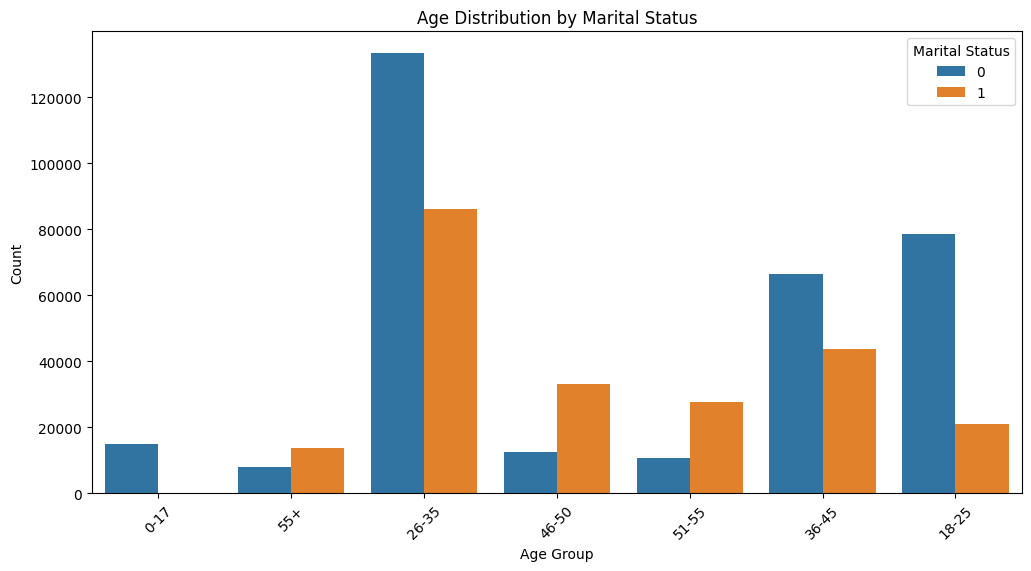

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Age', hue='Marital_Status', data=black_sale_data)
plt.title('Age Distribution by Marital Status')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marital Status')
plt.show()

Con esto podemos asumir que Marital_Status es 0 para solteros y 1 para casados, a sabiendas que quedan otros posibles significados afuera.

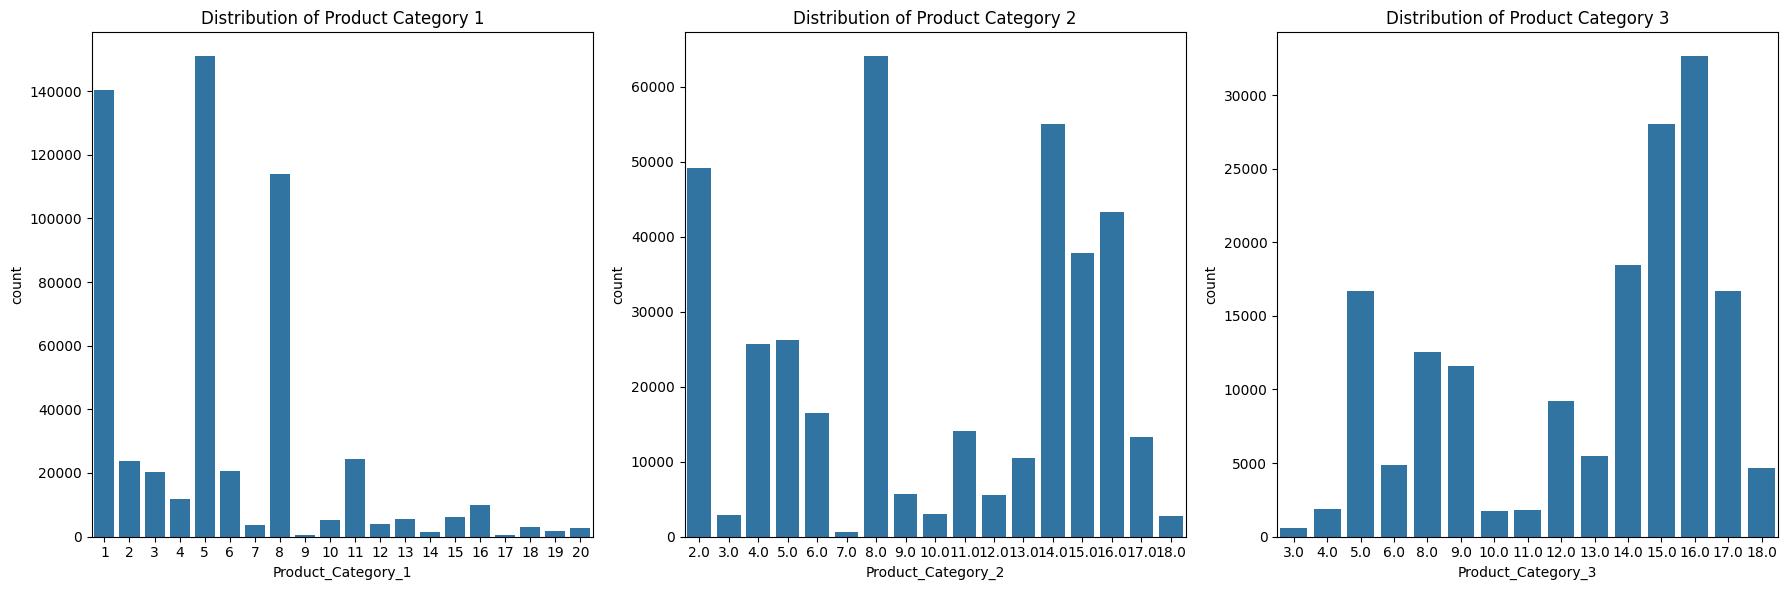

In [10]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Product_Category_1', data=black_sale_data)
plt.title('Distribution of Product Category 1')

plt.subplot(1, 3, 2)
sns.countplot(x='Product_Category_2', data=black_sale_data)
plt.title('Distribution of Product Category 2')

plt.subplot(1, 3, 3)
sns.countplot(x='Product_Category_3', data=black_sale_data)
plt.title('Distribution of Product Category 3')

plt.tight_layout()
plt.show()

Las distribuciones parecen indicar que se tratan de identificadores de productos dentro de las categorías. Desde ya, no tenemos noción de qué categorías corresponden.

In [11]:
# Find rows with the same product but different combinations of product categories
duplicates = black_sale_data[black_sale_data.duplicated(subset=['Product_ID'], keep=False)]
# Group by product ID and check for variations in product categories
product_category_variations = duplicates.groupby('Product_ID').agg({'Product_Category_1': 'nunique',
                                                                   'Product_Category_2': 'nunique',
                                                                   'Product_Category_3': 'nunique'})
# Filter for products with variations in any of the product categories
products_with_variations = product_category_variations[
    (product_category_variations['Product_Category_1'] > 1) |
    (product_category_variations['Product_Category_2'] > 1) |
    (product_category_variations['Product_Category_3'] > 1)
]
# Print the product IDs with variations
print("Product IDs with different category combinations:")
print(products_with_variations.index.tolist())

#Show the rows with those product IDs
print("\nRows with those Product IDs:")
print(black_sale_data[black_sale_data['Product_ID'].isin(products_with_variations.index)])

Product IDs with different category combinations:
[]

Rows with those Product IDs:
Empty DataFrame
Columns: [User_ID, Product_ID, Gender, Age, Occupation, City_Category, Stay_In_Current_City_Years, Marital_Status, Product_Category_1, Product_Category_2, Product_Category_3, Purchase]
Index: []


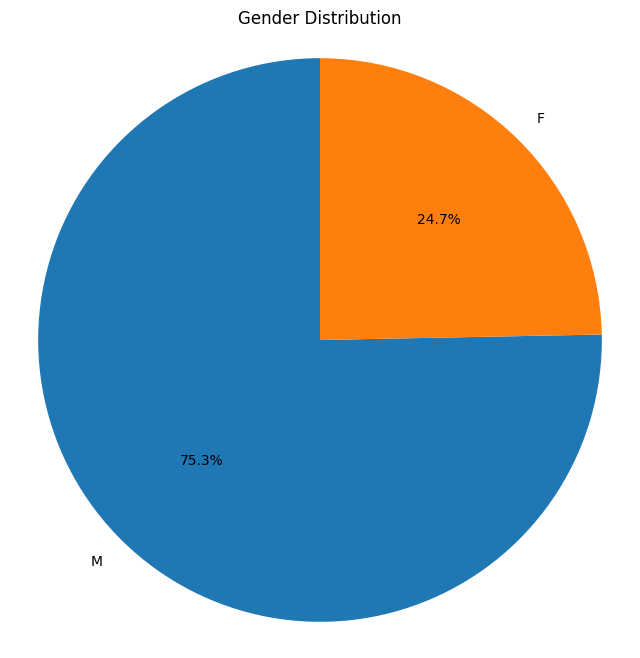

In [12]:
# Count the occurrences of each gender
gender_counts = black_sale_data['Gender'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

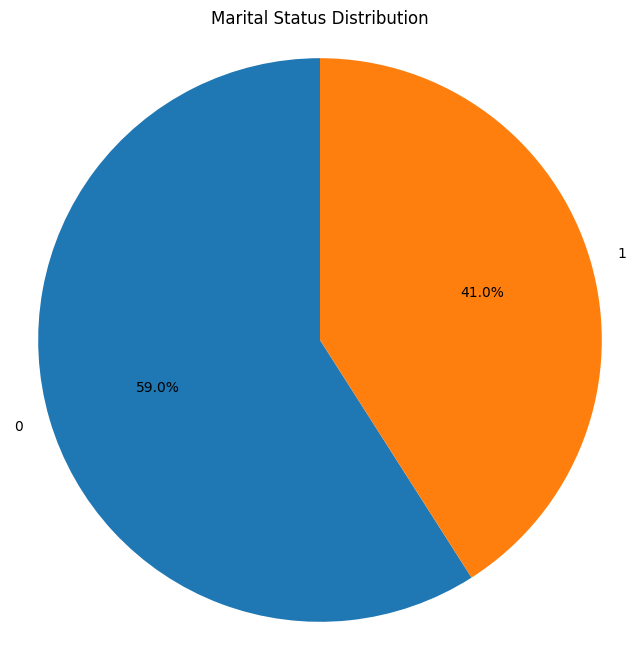

In [13]:
# Count the occurrences of each marital status
marital_status_counts = black_sale_data['Marital_Status'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(marital_status_counts, labels=marital_status_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Marital Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

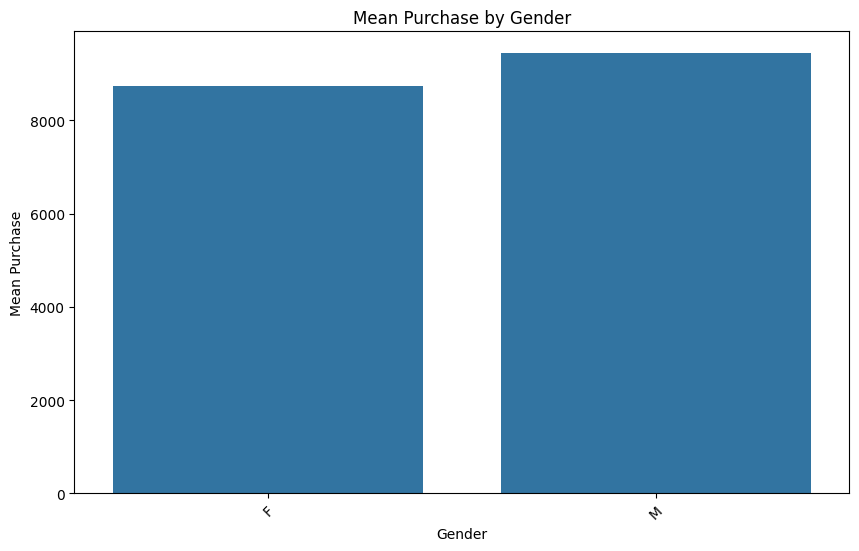

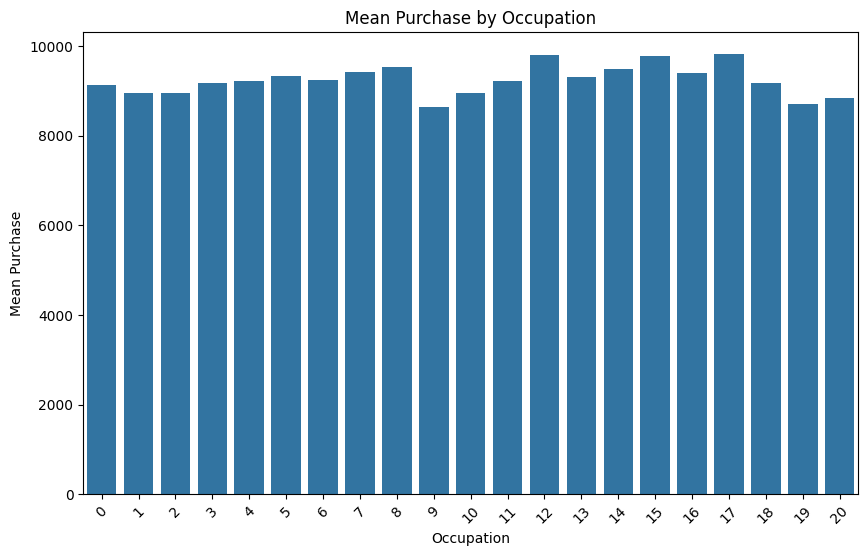

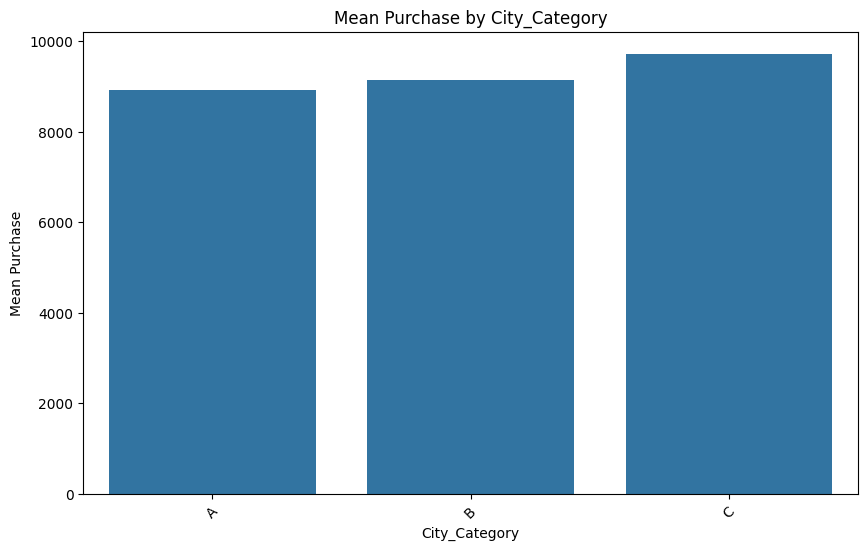

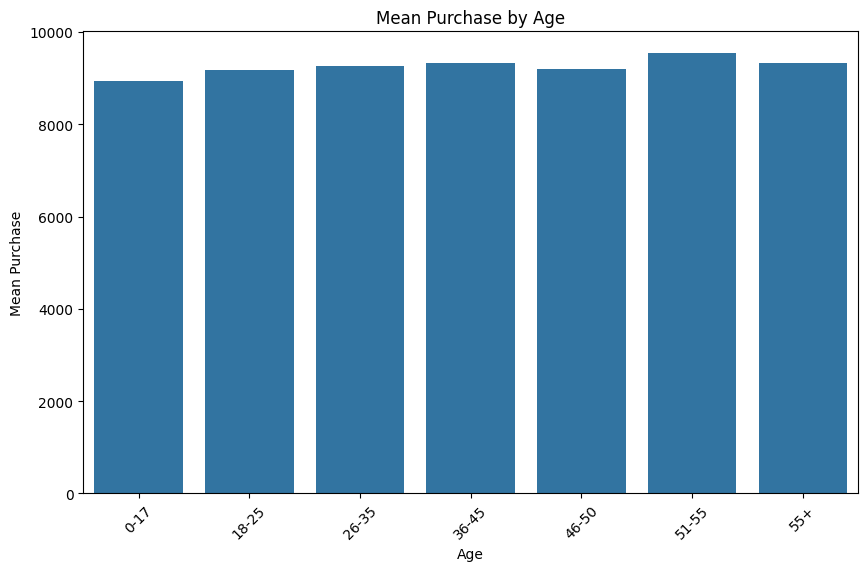

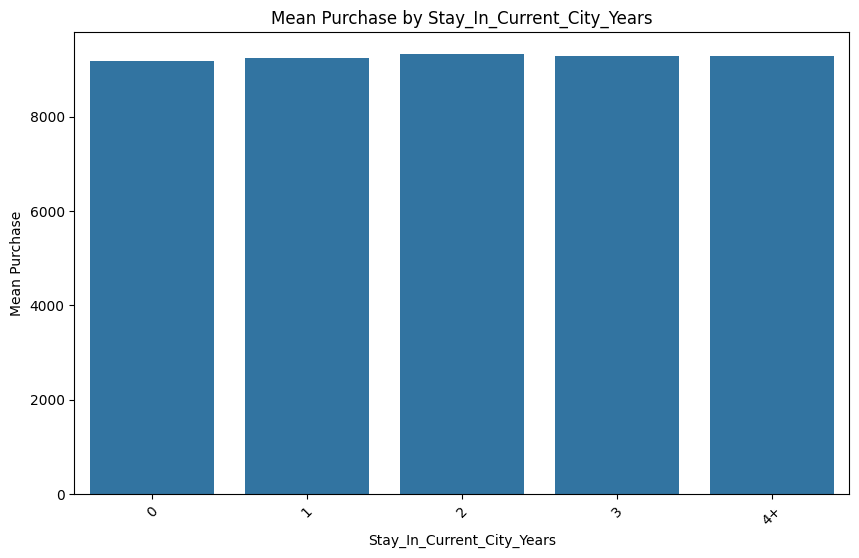

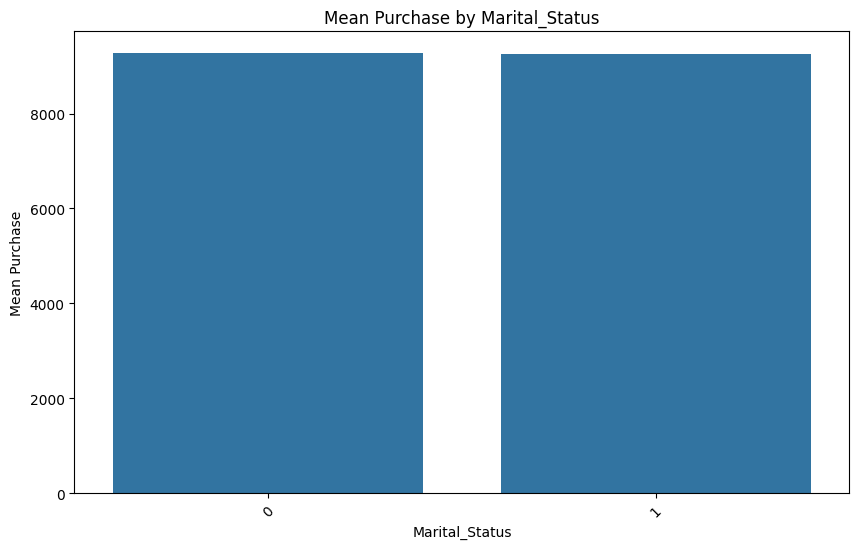

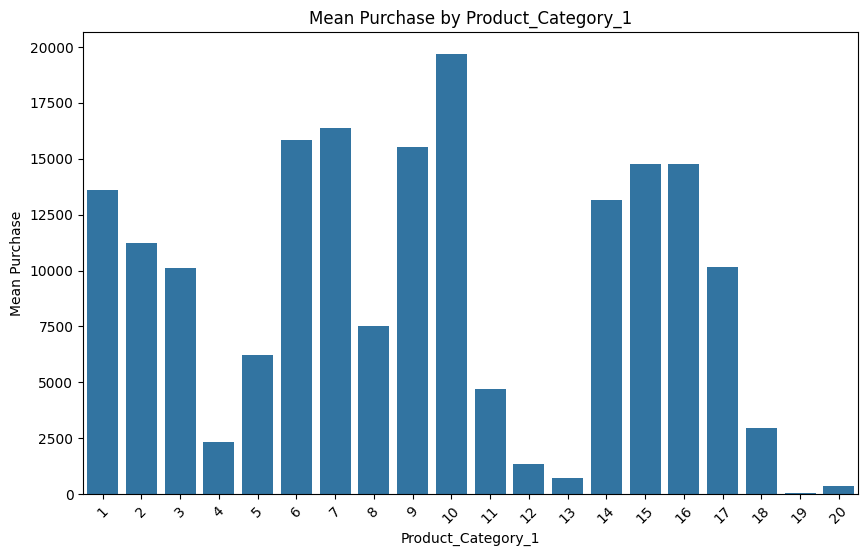

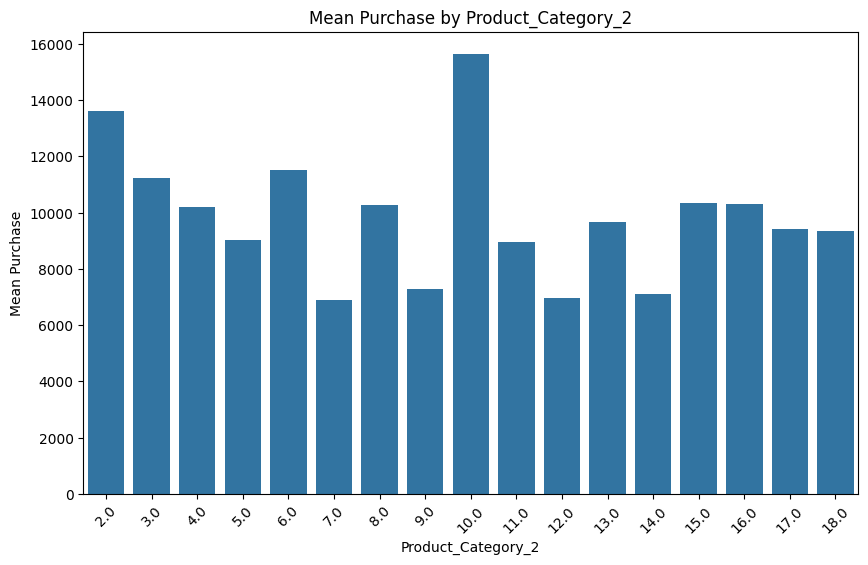

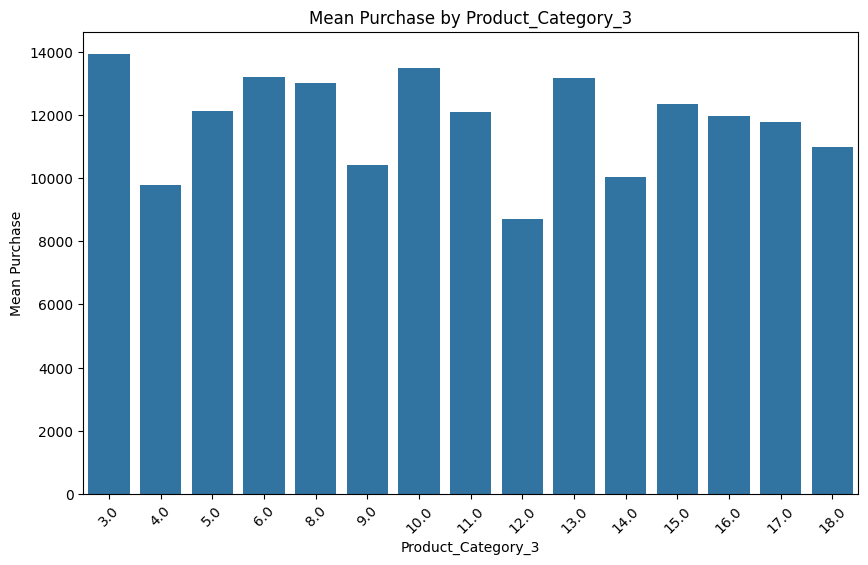

In [14]:
# Group data by each feature and calculate the mean purchase
features = ['Gender', 'Occupation', 'City_Category', 'Age', 'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']

for feature in features:
    purchase_mean_by_feature = black_sale_data.groupby(feature)['Purchase'].mean()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=purchase_mean_by_feature.index, y=purchase_mean_by_feature.values)
    plt.title(f'Mean Purchase by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Mean Purchase')
    plt.xticks(rotation=45)
    plt.show()

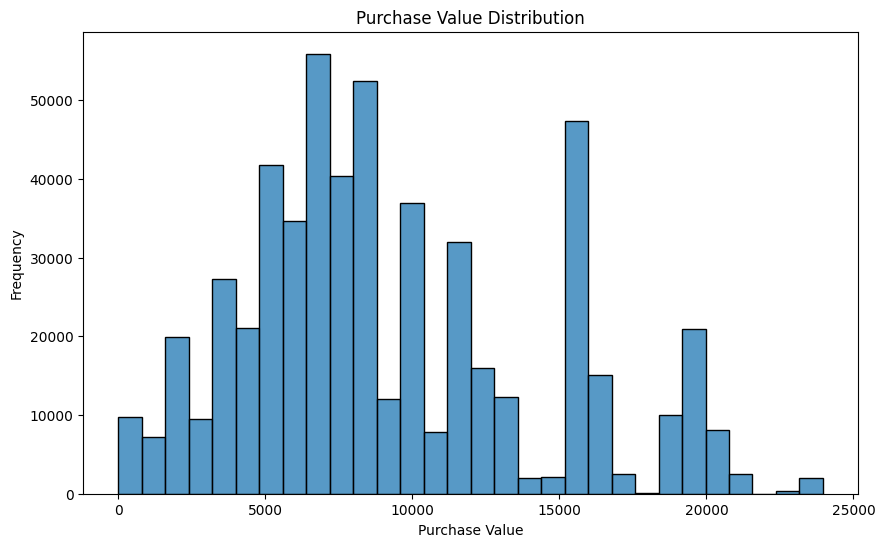

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(black_sale_data['Purchase'], bins=30)
plt.title('Purchase Value Distribution')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.show()

A este punto podemos inferir algunas cosas: Por la distribución de precios por categoría, podemos intuir que, los identificadores de categoría se comparten para las distintas features. Es decir, la categoría 10 en Product_Category_1, se corresponde a la misma categoría que cuando aparece en Product_Category_3. Además, vemos algunos picos en ocurrencias de ciertos rangos de precios, que se corresponden a picos en los promedios de precios pagados según la categoría, dando algún indicio de la importancia de la categoría para el rango de precio (lo cual hace sentido si imaginamos que las categorías pueden ser "electrónica", "ropa", "bazar", etc.)



Además, hay un problemas con los datos, y son los picos en 5000, 1000, 15000, que justo son los valores donde delimitamos las categorías a predecir, lo cual puede complicar al modelo a predecir correctamente el grupo de comprador.


### Feature Engineering ###

In [16]:
black_sale_data_processed = black_sale_data.copy()

In [17]:
for col in ['Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Occupation']:
    black_sale_data_processed[col] = black_sale_data_processed[col].fillna(-1).astype(int)

In [18]:
age_map = {
    '0-17': 0,
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-50': 4,
    '51-55': 5,
    '55+': 6
}
black_sale_data_processed['Age'] = black_sale_data_processed['Age'].map(age_map)

In [19]:
black_sale_data_processed['Stay_In_Current_City_Years'] = black_sale_data_processed['Stay_In_Current_City_Years'].replace('4+', 4).astype(int)

In [20]:
black_sale_data_processed['Marital_Status'] = black_sale_data_processed['Marital_Status'].map({0: 'Single', 1: 'Married'})

In [21]:
black_sale_data_processed = pd.get_dummies(black_sale_data_processed, columns=['Gender', 'Marital_Status', 'City_Category', 'Occupation'], drop_first=True)

In [22]:
# Create a copy of the original DataFrame for adding extra columns
black_sale_data_processed_with_extra_columns = black_sale_data_processed.copy()

# Identify all unique product categories from Product_Category_1, 2, and 3
unique_categories = set(black_sale_data_processed_with_extra_columns[['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].stack())

# Iterate through each unique category and create a new column
for category in unique_categories:
    black_sale_data_processed_with_extra_columns[f'Has_Product_Category_{category}'] = (
        (black_sale_data_processed_with_extra_columns['Product_Category_1'] == category) |
        (black_sale_data_processed_with_extra_columns['Product_Category_2'] == category) |
        (black_sale_data_processed_with_extra_columns['Product_Category_3'] == category)
    ).astype(int)
black_sale_data_processed_with_extra_columns = black_sale_data_processed_with_extra_columns.drop(columns=['Has_Product_Category_-1'])

In [23]:
black_sale_data_processed = pd.get_dummies(black_sale_data_processed, columns=['Product_Category_1', 'Product_Category_2', 'Product_Category_3'], drop_first=True)


In [24]:
black_sale_data_processed

,User_ID,Product_ID,Age,Stay_In_Current_City_Years,Purchase,Gender_M,Marital_Status_Single,City_Category_B,City_Category_C,Occupation_1,...,Product_Category_3_9,Product_Category_3_10,Product_Category_3_11,Product_Category_3_12,Product_Category_3_13,Product_Category_3_14,Product_Category_3_15,Product_Category_3_16,Product_Category_3_17,Product_Category_3_18
0,1000001,P00069042,0,2,8370,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1000001,P00248942,0,2,15200,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,1000001,P00087842,0,2,1422,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1000001,P00085442,0,2,1057,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1000002,P00285442,6,4,7969,True,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,P00372445,5,1,368,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
550064,1006035,P00375436,2,3,371,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
550065,1006036,P00375436,2,4,137,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
550066,1006038,P00375436,6,2,365,False,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False


In [26]:
bins = [0, 5000, 10000, 15000, float('inf')]  # Límites de los rangos
labels = [0, 1, 2, 3]  # Grupos correspondientes
black_sale_data_processed['Purchase_Group'] = pd.cut(
    black_sale_data_processed['Purchase'],
    bins=bins,
    labels=labels,
    right=False  # Excluye el límite superior del rango
)

In [27]:
print(black_sale_data_processed['Purchase_Group'].value_counts())

Purchase_Group
1    265606
3    110523
0     94923
2     79016
Name: count, dtype: int64


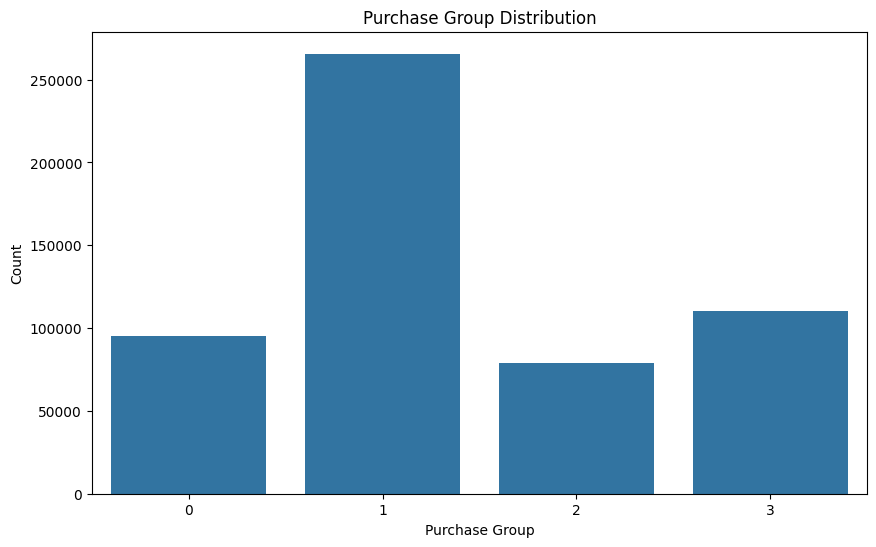

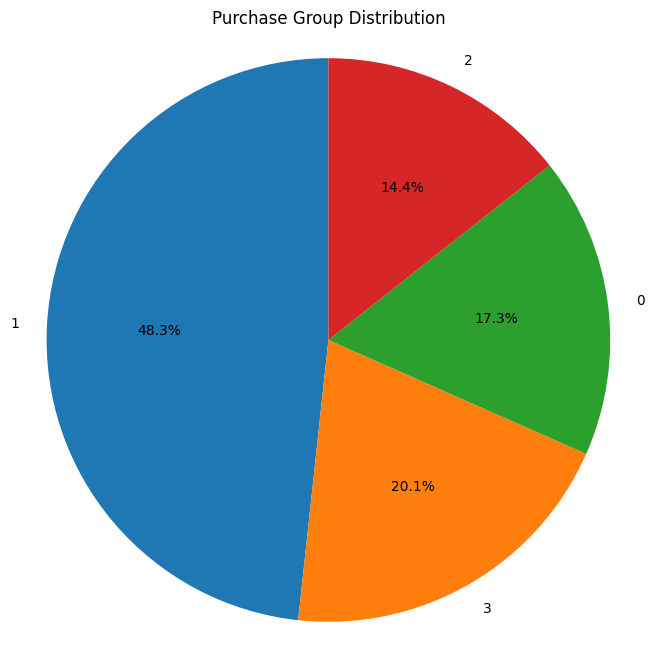

In [28]:
# prompt: graficar distribucion de barras de las Purchase_Group y porcentajes de cada una con grafico torta

# Count the occurrences of each purchase group
purchase_group_counts = black_sale_data_processed['Purchase_Group'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=purchase_group_counts.index, y=purchase_group_counts.values)
plt.title('Purchase Group Distribution')
plt.xlabel('Purchase Group')
plt.ylabel('Count')
plt.show()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(purchase_group_counts, labels=purchase_group_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Purchase Group Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [29]:
# prompt: check isna() for each field

# Check for NaN values in each column of the DataFrame
for col in black_sale_data_processed.columns:
  print(f"Column '{col}': Number of NaN values - {black_sale_data_processed[col].isna().sum()}")

Column 'User_ID': Number of NaN values - 0
Column 'Product_ID': Number of NaN values - 0
Column 'Age': Number of NaN values - 0
Column 'Stay_In_Current_City_Years': Number of NaN values - 0
Column 'Purchase': Number of NaN values - 0
Column 'Gender_M': Number of NaN values - 0
Column 'Marital_Status_Single': Number of NaN values - 0
Column 'City_Category_B': Number of NaN values - 0
Column 'City_Category_C': Number of NaN values - 0
Column 'Occupation_1': Number of NaN values - 0
Column 'Occupation_2': Number of NaN values - 0
Column 'Occupation_3': Number of NaN values - 0
Column 'Occupation_4': Number of NaN values - 0
Column 'Occupation_5': Number of NaN values - 0
Column 'Occupation_6': Number of NaN values - 0
Column 'Occupation_7': Number of NaN values - 0
Column 'Occupation_8': Number of NaN values - 0
Column 'Occupation_9': Number of NaN values - 0
Column 'Occupation_10': Number of NaN values - 0
Column 'Occupation_11': Number of NaN values - 0
Column 'Occupation_12': Number of

In [30]:
X = black_sale_data_processed.drop(columns=['Purchase', 'Purchase_Group', 'User_ID', 'Product_ID'])
y = black_sale_data_processed['Purchase_Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [33]:
y_pred_logistic = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.81      0.45      0.58     18985
           1       0.82      0.84      0.83     53121
           2       0.53      0.27      0.35     15803
           3       0.57      0.95      0.71     22105

    accuracy                           0.71    110014
   macro avg       0.68      0.63      0.62    110014
weighted avg       0.73      0.71      0.69    110014



Accuracy: 0.7127
Precision: 0.7251
Recall: 0.7127
F1-Score: 0.6937

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.45      0.58     18985
           1       0.82      0.84      0.83     53121
           2       0.53      0.27      0.35     15803
           3       0.57      0.95      0.71     22105

    accuracy                           0.71    110014
   macro avg       0.68      0.63      0.62    110014
weighted avg       0.73      0.71      0.69    110014


Confusion Matrix:
[[ 8492  7990   409  2094]
 [ 1902 44665  2479  4075]
 [   17  1901  4199  9686]
 [   16   182   859 21048]]
AUC Score: 0.8668


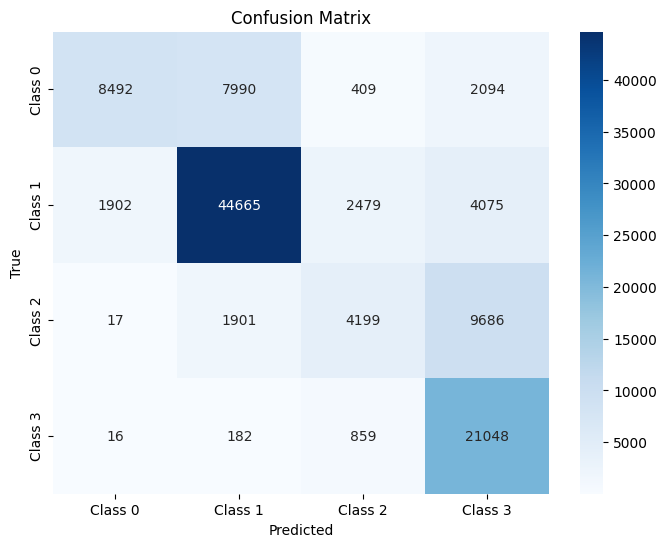

In [34]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_logistic)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_logistic, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))

# For AUC (One-vs-Rest), you need probability scores for each class
# This will apply only to Logistic Regression and RandomForest (for multi-class classification)
if hasattr(clf, "predict_proba"):
    y_prob = clf.predict_proba(X_test_scaled)  # Predicted probabilities
    auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"AUC Score: {auc_score:.4f}")

# Assuming `y_test` are the true labels and `y_pred` are the predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_logistic)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [35]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [36]:
y_pred_random_forest = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.72      0.46      0.56     18985
           1       0.78      0.85      0.82     53121
           2       0.43      0.36      0.39     15803
           3       0.62      0.75      0.68     22105

    accuracy                           0.69    110014
   macro avg       0.64      0.61      0.61    110014
weighted avg       0.69      0.69      0.68    110014



Accuracy: 0.6933
Precision: 0.6884
Recall: 0.6933
F1-Score: 0.6830

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.46      0.56     18985
           1       0.78      0.85      0.82     53121
           2       0.43      0.36      0.39     15803
           3       0.62      0.75      0.68     22105

    accuracy                           0.69    110014
   macro avg       0.64      0.61      0.61    110014
weighted avg       0.69      0.69      0.68    110014


Confusion Matrix:
[[ 8664  8361   765  1195]
 [ 2515 45290  2736  2580]
 [  388  3131  5646  6638]
 [  419  1093  3917 16676]]
AUC Score: 0.8583


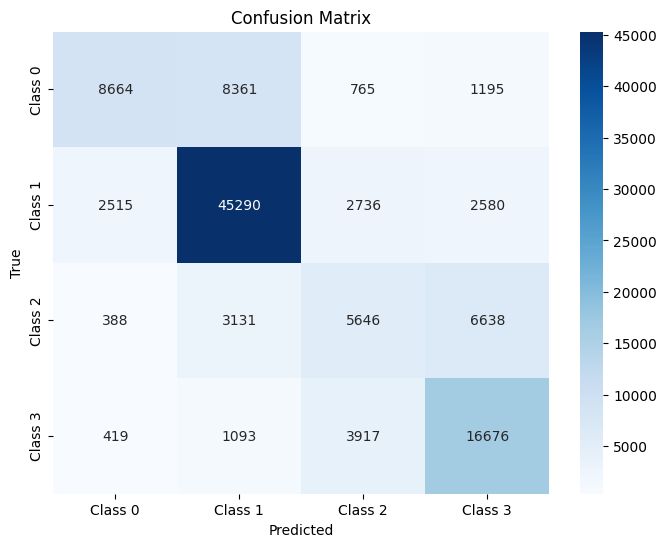

In [37]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-Score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_random_forest, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_random_forest))

# For AUC (One-vs-Rest), you need probability scores for each class
# This will apply only to Logistic Regression and RandomForest (for multi-class classification)
if hasattr(clf, "predict_proba"):
    y_prob = clf.predict_proba(X_test_scaled)  # Predicted probabilities
    auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"AUC Score: {auc_score:.4f}")

# Assuming `y_test` are the true labels and `y_pred` are the predicted labels
conf_matrix = confusion_matrix(y_test, y_pred_random_forest)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Vemos los problemas que intuímos ibamos a tener por los datos y los rangos de precios de los grupos solicitados. Vemos que ambos modelos predicen muchos casos de Clase 0 como Clase 1 y Clase 2 como Clase 3. Los que mejor funcionan son las prediciones de Clase 1 y 3, dado que son las que más observaciones presentan. Este comportamiento está relacionado con los picos que observamos en valores cercanos a 10.000 y 15.000, que complican al modelo para diferenciar correctamente la clase.

### Normalización ###

In [38]:
X_numpy = X.to_numpy(dtype='float')
y_numpy = y.to_numpy(dtype='float')

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y)

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
class BlackSaleDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [42]:
train_black_sale_ds = BlackSaleDataset(X_train_scaled, y_train)

In [44]:
X_train_scaled.shape

(440054, 77)

In [43]:
train_black_sale_ds[20]

(array([-0.36692798, -0.66516628, -1.74840469,  0.83314153, -0.85276353,
        -0.67111783, -0.30749879, -0.22542739, -0.18215319, -0.38940489,
        -0.1501398 , -0.19588299,  2.88031168, -0.05300756, -0.10786413,
        -0.15511329, -0.14619944, -0.24538795, -0.119406  , -0.22809177,
        -0.1500844 , -0.22012854, -0.28023562, -0.10993655, -0.12457683,
        -0.25464373, -0.21323693, -0.19501201, -0.14828567, -0.61518386,
        -0.19622047, -0.08293349,  1.95897057, -0.02776606, -0.09714463,
        -0.21502456, -0.08508697, -0.10078554, -0.0525747 , -0.1075943 ,
        -0.13455922, -0.03294137, -0.07593714, -0.05424355, -0.06795877,
        -0.31335038, -0.07262755, -0.22099527, -0.22430086, -0.17576957,
        -0.0338955 , -0.36370378, -0.10172466, -0.07474744, -0.16203367,
        -0.10075103, -0.13956692, -0.33364297, -0.2722014 , -0.29195445,
        -0.15787949, -0.07176883, -0.03255892, -0.05860085, -0.17596183,
        -0.09493952, -0.15295645, -0.14681443, -0.0

In [45]:
train_dataloader = DataLoader(X_train_scaled, batch_size = 64, shuffle=True)
test_dataloader = DataLoader(X_test_scaled, batch_size=64)

In [46]:
class NNet(torch.nn.Module):

  def __init__(self, input_size, output_size):
    # Defino la arquitectura de la red
    super().__init__()
    self.linear_1 = torch.nn.Linear(in_features=input_size, out_features=200, bias=True)
    self.relu_1 = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features=200, out_features=100, bias=True)
    self.relu_2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features=100, out_features=output_size, bias=True)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    x = self.softmax(x)
    return x

In [48]:
input_size = X_train.shape[1]  # Número de características de entrada
output_size = 4  # Número de clases (en tu caso, 4 grupos de gasto)

# Crear el modelo
model = NNet(input_size, output_size)

# Configurar el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [49]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

# Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros:
- numero de capas.
- numero de kernels.
- tamaño de kernels.


Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo en una gráfica con las curvas de los 5 modelos propuestos. Compare también el tiempo de entrenamiento y peso (tamaño) de cada modelo. Aplique técnicas de regularización para evitar overfitting. Elija el modelo que considera mejor y justifique.
Entregables:
 - Grafica comparativa de función de perdida vs epochs para los 5 modelos.
 - Grafica comparativa de función de accuracy vs epochs para los 5 modelos.
 - Tabla comparativa (o grafico de barras) del tiempo de entrenamiento y pesos de cada modelo.
 - Justificación del modelo elegio (qué consideró para elegir el modelo y bajo qué criterio).



In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)


In [ ]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior **(NO USAR RESNET U OTRO MODELO DISPONIBLE, TIENE QUE USAR EL QUE UD DESARROLLÓ)**, realice transfer learning para procesar las imágenes del dataset MNIST (los números) **e identificar los números mayores o menores a 4,5**.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. Al reducir el train set, mantenga equilibrada la distribución de las clases.

Elija la estrategia de transfer learning acorde a los visto en la teoría y justifique su elección.

Compare las curvas de entrenamiento y accurracy empleando transfer learning o usando la arquitectura elejida en el punto anterior pero entrenando desde cero.
Entregables:
- Estrategia elegida y su justificación.
- Grafica comparativa de función de perdida vs epochs para el modelo con transfer learning y sin transfer learning.
- Grafica comparativa de función de accuracy vs epochs para el modelo con transfer learning y sin transfer learning.
- Comentarios sobre las curvas graficadas.
